In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fuyadhasanbhoyan/knee-osteoarthritis-classification-224224")

print("Path to dataset files:", path)
os.listdir(path)

2025-02-04 20:15:25.010039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738689325.116690     761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738689325.145645     761 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 20:15:25.390623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Path to dataset files: /home/yagiz_dev/.cache/kagglehub/datasets/fuyadhasanbhoyan/knee-osteoarthritis-classification-224224/versions/1


['Knee Osteoarthritis Classification']

In [2]:
import cv2
import random
IMG_WIDTH,IMG_HEIGHT=224,224

In [3]:
data_path = os.path.join(path,"Knee Osteoarthritis Classification")
os.listdir(data_path)

['train', 'test', 'val']

In [4]:
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")

In [5]:
num_classes=len(os.listdir(train_path))
class_names = os.listdir(train_path)

In [6]:
def show_images(path,num_images=6):
    plt.figure(figsize=(10,6))
    for i in range(num_images):
        plt.subplot(2,3,i+1)
        class_name = random.choice(os.listdir(path))
        class_path = os.path.join(path,class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path,img_name)
        img = plt.imread(img_path)
        img = cv2.resize(img,(IMG_HEIGHT,IMG_WIDTH))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

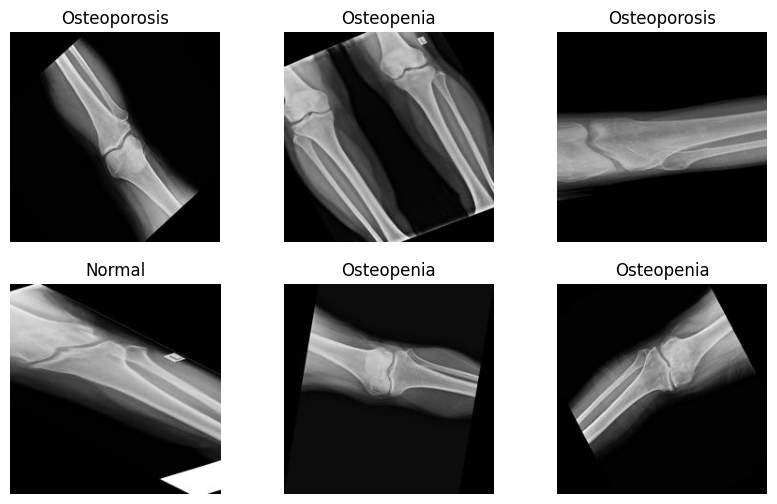

In [7]:
show_images(train_path)

In [8]:
import seaborn as sns
def class_distribution(path):
    class_dict = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path,class_name)
        class_dict[class_name] = len(os.listdir(class_path))
    return class_dict

train_dist = class_distribution(train_path)
val_dist = class_distribution(val_path)
test_dist = class_distribution(test_path)
total_dist = {k:train_dist.get(k,0)+val_dist.get(k,0)+test_dist.get(k,0) for k in set(train_dist)|set(val_dist)|set(test_dist)}

In [9]:
def plot_distribution(data,title):
    sns.barplot(x=list(data.keys()),y=list(data.values()))
    plt.title(title)
    plt.show()

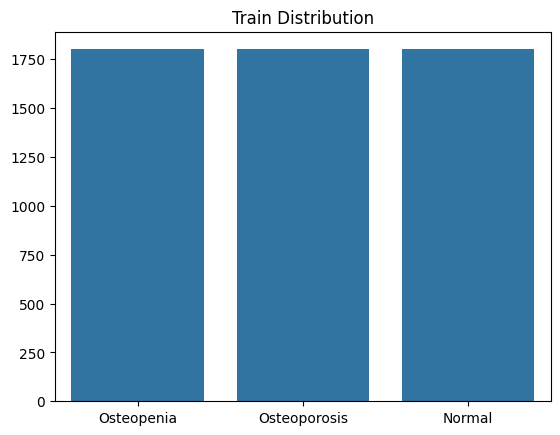

In [10]:
plot_distribution(total_dist,"Train Distribution")

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=30,zoom_range=0.2,shear_range=0.2,width_shift_range=0.2,height_shift_range=0.2,fill_mode="nearest")
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=32,class_mode="categorical")
val_generator = val_datagen.flow_from_directory(val_path,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=32,class_mode="categorical")
test_generator = val_datagen.flow_from_directory(test_path,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=32,class_mode="categorical")

Found 3780 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.
Found 540 images belonging to 3 classes.


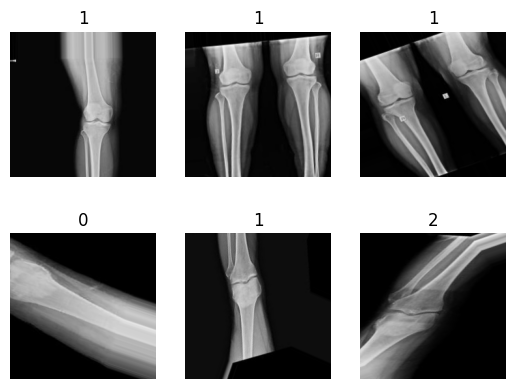

In [13]:
img,labels = next(train_generator)

for  i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(img[i])
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

In [14]:
class Classifier():
    def get_callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint("classifier.keras",save_best_only=True)
        return [early_stopping,model_checkpoint]
    def build_model(self,learning_rate=0.001):
        input = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
        x = tf.keras.layers.Conv2D(32,(3,3),activation="relu")(input)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Conv2D(64,(3,3),activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(256,activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(128,activation="relu")(x)
        outputs = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
        model = tf.keras.models.Model(input,outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
        return model
    def train_model(self,train_generator,val_generator,epochs=20):
        model = self.build_model()
        history = model.fit(train_generator,epochs=epochs,validation_data=val_generator,callbacks=self.get_callbacks())
        return history,model

    def evaluate_model(self,model,test_generator):
        loss,acc = model.evaluate(test_generator)
        return loss,acc

In [15]:
class Visualizer():
    def plot_history(self,history):
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(history.history["accuracy"],label="Train Accuracy")
        plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
        plt.legend()
        plt.title("Accuracy")
        plt.subplot(1,2,2)
        plt.plot(history.history["loss"],label="Train Loss")
        plt.plot(history.history["val_loss"],label="Validation Loss")
        plt.legend()
        plt.title("Loss")
        plt.show()
    
    def plot_confusion_matrix(self,model,test_generator):
        y_pred = model.predict(test_generator)
        y_pred = np.argmax(y_pred,axis=1)
        y_true = test_generator.classes
        cm = tf.math.confusion_matrix(y_true,y_pred)
        plt.figure(figsize=(10,6))
        sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    def plot_predicts(self,model,test_generator,class_names: list):
        plt.figure(figsize=(10,6))
        for i in range(6):
            plt.subplot(2,3,i+1)
            img,label = next(test_generator)
            img = img[0]
            label = label[0]
            plt.imshow(img)
            plt.title(f"Actual: {class_names[np.argmax(label)]}\nPredicted: {class_names[np.argmax(model.predict(img[np.newaxis]))]}")
            plt.axis("off")
        plt.show()

I0000 00:00:1738689332.088916     761 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3588 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/yagiz_dev/Anaconda3/envs/tfkeras/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1738689334.677965     920 service.cc:148] XLA service 0x7fc498004b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738689334.678463     920 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-04 20:15:34.724658: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738689334.923133     920 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/119 ━━━━━━━━━━━━━━━━━━━━ 14:43 7s/step - accuracy: 0.2812 - loss: 1.1002

I0000 00:00:1738689340.955727     920 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 86/119 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.3718 - loss: 1.0951

2025-02-04 20:16:01.788445: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_930', 8 bytes spill stores, 8 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.3740 - loss: 1.0940 - val_accuracy: 0.3315 - val_loss: 1.1371
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.4273 - loss: 1.0635 - val_accuracy: 0.3380 - val_loss: 1.1556
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step - accuracy: 0.4351 - loss: 1.0363 - val_accuracy: 0.3528 - val_loss: 1.1584
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - accuracy: 0.4757 - loss: 0.9911 - val_accuracy: 0.3528 - val_loss: 1.2241
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.5106 - loss: 0.9798 - val_accuracy: 0.3926 - val_loss: 1.2070
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.5061 - loss: 0.9677 - val_accuracy: 0.3722 - val_loss: 1.1164
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.5281 - loss: 0.9518 - val_accuracy: 0.4074 - val_loss: 1.1945
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 211ms/step - accuracy: 0.4882 - loss: 0.9733 - val

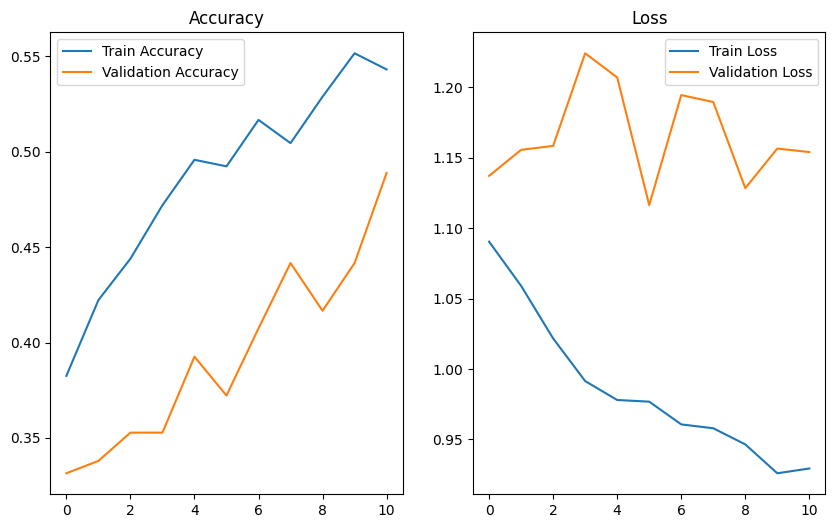

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.4946 - loss: 0.9624
Loss: 0.9892644882202148, Accuracy: 0.4574074149131775
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


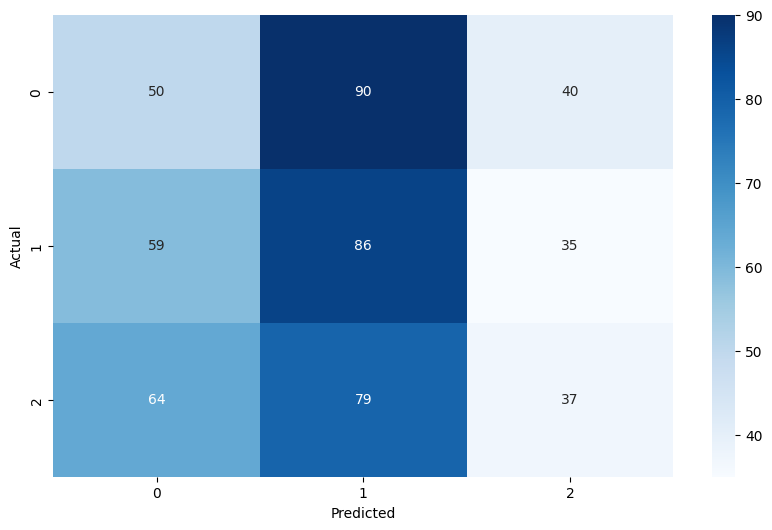

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


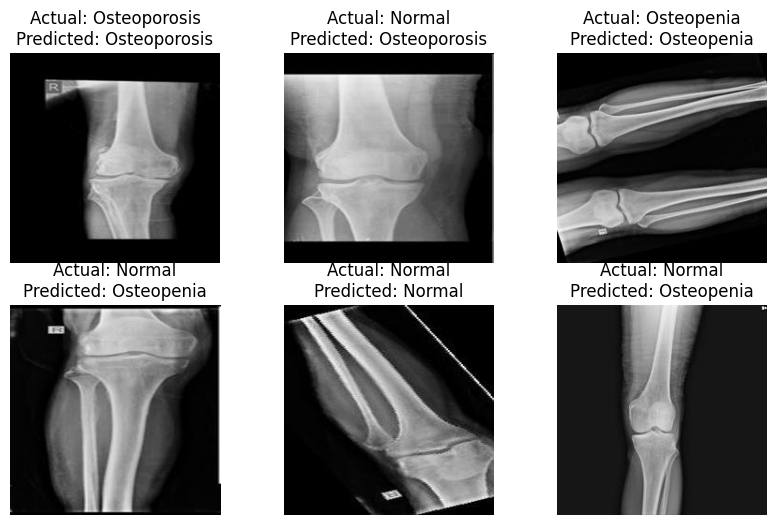

In [16]:
classifier = Classifier()
history,model = classifier.train_model(train_generator,val_generator)
visualizer = Visualizer()
visualizer.plot_history(history)
loss,acc = classifier.evaluate_model(model,test_generator)
print(f"Loss: {loss}, Accuracy: {acc}")
visualizer.plot_confusion_matrix(model,test_generator)
visualizer.plot_predicts(model,test_generator,class_names)